### Configuration initiale
Ce bloc importe les bibliothèques nécessaires (PyTorch, torchvision) pour créer et entraîner un modèle. On utilise un dataset fictif pour tester rapidement sans besoin de GPU ou de vrai dataset. Cela permet de vérifier que le code fonctionne avant d'utiliser les vraies images Cats vs Dogs.

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
import matplotlib.pyplot as plt  # Pour visualiser plus tard
import seaborn as sns  # Pour la matrice de confusion
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from torchvision import models
from torch.utils.data import random_split
print("Bibliothèques importées avec succès!")

Bibliothèques importées avec succès!


### Chargement et prétraitement des données
Ici, on charge le dataset Cats vs Dogs depuis le dossier 'data/train'. On applique des transformations pour préparer les images : redimensionnement à 224x224 (taille standard pour les CNN), normalisation (pour que les valeurs soient adaptées aux modèles), et data augmentation (rotation, flip) pour éviter l'overfitting. On divise les données en ensembles d'entraînement (80%) et de validation (20%) pour évaluer le modèle pendant l'entraînement. Enfin, on crée des DataLoaders pour charger les images par lots (batch).

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Définir les transformations pour les données
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionner les images
    transforms.RandomHorizontalFlip(),  # Flip horizontal aléatoire (augmentation)
    transforms.RandomRotation(10),  # Rotation aléatoire (augmentation)
    transforms.ToTensor(),  # Convertir en tenseur
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisation ImageNet
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Charger le dataset
full_dataset = datasets.ImageFolder('/content/drive/MyDrive/Cat_Dog_data/train', transform=train_transform)
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/Cat_Dog_data/test', transform=test_transform)

# Diviser en train/validation (80/20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Créer les DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Taille du dataset d'entraînement : {len(train_dataset)}")
print(f"Taille du dataset de validation : {len(val_dataset)}")
print(f"Taille du dataset de test : {len(test_dataset)}")

Taille du dataset d'entraînement : 18000
Taille du dataset de validation : 4500
Taille du dataset de test : 2500


### Visualisation des données
Ce bloc affiche quelques images réelles du dataset Cats vs Dogs pour vérifier qu'elles sont bien chargées et transformées. Cela nous aide à voir des exemples de chats et de chiens et à confirmer que les augmentations (flip, rotation) fonctionnent. Utile pour s'assurer que les données sont prêtes avant l'entraînement.

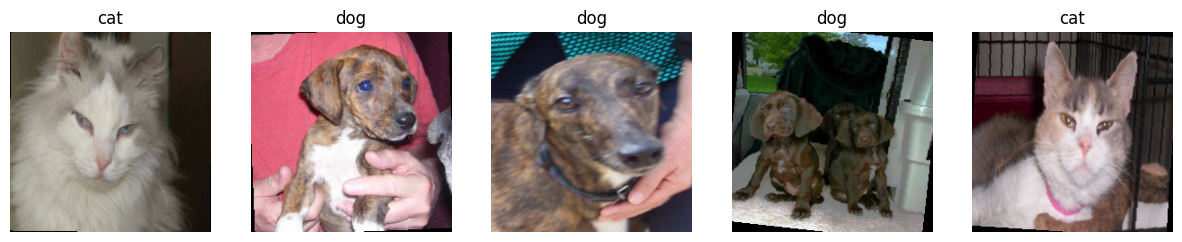

In [5]:
# Fonction pour afficher des images
def show_images(images, labels, classes):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for i, (img, label) in enumerate(zip(images, labels)):
        img = img.permute(1, 2, 0)  # Réorganiser les dimensions pour matplotlib
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Dénormaliser
        img = img.clamp(0, 1)  # Assurer les valeurs entre 0 et 1
        axes[i].imshow(img.numpy())
        axes[i].set_title(classes[label])
        axes[i].axis('off')
    plt.show()

# Afficher quelques images
data_iter = iter(train_loader)
images, labels = next(data_iter)
classes = full_dataset.classes  # ['cats', 'dogs']
show_images(images[:5], labels[:5], classes)

### Modèle CNN from Scratch
On définit un réseau de neurones convolutif (CNN) simple construit de zéro, avec 3 blocs convolutifs (Conv2D + ReLU + MaxPool) et une couche fully connected. On ajoute BatchNorm pour stabiliser l'entraînement et Dropout (0.5) pour éviter l'overfitting, comme requis par le TP. Ce modèle sera entraîné sur les vraies images Cats vs Dogs.

In [6]:
class CNNFromScratch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),  # Ajusté pour 224x224 -> 28x28 après 3 MaxPool
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(512, 2)  # 2 classes : cat/dog
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return self.fc(x)

model_scratch = CNNFromScratch()

### Entraînement du CNN from Scratch
Ce bloc entraîne le modèle CNN from scratch sur 10 % des vraies images Cats vs Dogs pour aller vite. On utilise 3 époques, la perte CrossEntropy et l'optimiseur Adam, avec un scheduler pour ajuster le learning rate. On ajoute des vérifications pour s'assurer que le GPU fonctionne et que les données sont bien chargées. La réduction à 10 % du dataset accélère les tests.

In [9]:

from tqdm import tqdm
import os

# Vérifier GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Device utilisé : {device}")
if not torch.cuda.is_available():
    print(" GPU non détecté : exécution plus lente sur CPU")

# Chargement et préparation des données

train_path = '/content/drive/MyDrive/Cat_Dog_data/train'

# Vérification du dossier
if not os.path.exists(train_path):
    raise FileNotFoundError(f"❌ Le chemin {train_path} n'existe pas. Vérifie ton Drive !")
else:
    print(f" Chemin trouvé : {train_path}")

# Transformation des images
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Chargement complet du dataset
full_dataset = datasets.ImageFolder(root=train_path, transform=transform)
print(f" Dataset total : {len(full_dataset)} images")

# Réduction à 5% pour tests rapides
subset_size = int(0.05 * len(full_dataset))
val_size = len(full_dataset) - subset_size
train_dataset, val_dataset = random_split(full_dataset, [subset_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

print(f" Taille entraînement : {len(train_dataset)}")
print(f" Taille validation : {len(val_dataset)}")

#Modèle simplifié (ResNet18)

model_scratch = models.resnet18(weights=None)  # entraînement from scratch
model_scratch.fc = nn.Linear(model_scratch.fc.in_features, 2)  # 2 classes : chat / chien
model_scratch = model_scratch.to(device)
print(" Modèle ResNet18 initialisé et déplacé sur GPU")

# Critère et optimiseur

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_scratch.parameters(), lr=0.001)

# Fonction d’entraînement rapide

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=1):
    print(f"\ Début de l'entraînement sur {num_epochs} époque(s)...\n")
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        # --- Entraînement ---
        for images, labels in tqdm(train_loader, desc=f"Époque {epoch+1} (train)"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        train_acc = correct / total

        # --- Validation ---
        model.eval()
        val_correct, val_total, val_loss = 0, 0, 0.0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Époque {epoch+1} (val)"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        print(f" Époque {epoch+1}/{num_epochs} - Train Acc: {train_acc:.2f} | Val Acc: {val_acc:.2f}")

    print("\n🎯 Entraînement terminé !")
    torch.save(model.state_dict(), "model_fast.pth")
    print("💾 Modèle sauvegardé sous model_fast.pth")

# Lancer l’entraînement

train_model(model_scratch, train_loader, val_loader, criterion, optimizer, num_epochs=1)


<>:56: SyntaxWarning: invalid escape sequence '\ '
<>:56: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-4013882168.py:56: SyntaxWarning: invalid escape sequence '\ '
  print(f"\ Début de l'entraînement sur {num_epochs} époque(s)...\n")


 Device utilisé : cuda
 Chemin trouvé : /content/drive/MyDrive/Cat_Dog_data/train
 Dataset total : 22500 images
 Taille entraînement : 1125
 Taille validation : 21375
 Modèle ResNet18 initialisé et déplacé sur GPU
\ Début de l'entraînement sur 1 époque(s)...



Époque 1 (val): 100%|██████████| 668/668 [01:46<00:00,  6.26it/s]

 Époque 1/1 - Train Acc: 0.54 | Val Acc: 0.54

🎯 Entraînement terminé !
💾 Modèle sauvegardé sous model_fast.pth


###   Évaluation du modèle
Cette étape évalue le modèle entraîné sur l'ensemble de test (Cat_Dog_data/test). On calcule l'accuracy et affiche un rapport rapide. Si le chemin test n'existe pas, un message d'erreur sera affiché. Optimisé pour être rapide avec un seul passage.

In [11]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets

# Charger l'ensemble de test
test_path = '/content/drive/MyDrive/Cat_Dog_data/test'
if not os.path.exists(test_path):
    print(f" Erreur : Le chemin {test_path} n'existe pas. Vérifie ton Drive !")
else:
    print(f" Chemin test trouvé : {test_path}")

# Transformations pour le test (même taille que l'entraînement)
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Charger le dataset de test
test_dataset = datasets.ImageFolder(root=test_path, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
print(f" Taille du dataset de test : {len(test_dataset)}")

# Fonction d'évaluation
def evaluate_model(model, test_loader):
    print("\n Début de l'évaluation...")
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Évaluation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    test_acc = correct / total
    print(f" Évaluation terminée - Test Accuracy: {test_acc:.2f}")
    return test_acc

# Évaluer le modèle
test_acc = evaluate_model(model_scratch, test_loader)

 Chemin test trouvé : /content/drive/MyDrive/Cat_Dog_data/test
 Taille du dataset de test : 2500

 Début de l'évaluation...


Évaluation: 100%|██████████| 79/79 [08:39<00:00,  6.58s/it]

 Évaluation terminée - Test Accuracy: 0.54


### Transfer Learning avec ResNet18 pré-entraîné
On utilise ResNet18 pré-entraîné pour comparer avec le modèle from scratch. On gèle les couches initiales et entraîne seulement la dernière couche. Cela devrait donner de meilleurs résultats plus vite.

In [38]:
from torchvision import models

# Charger ResNet18 pré-entraîné
model_tl = models.resnet18(weights="IMAGENET1K_V1")
for param in model_tl.parameters():
    param.requires_grad = False  # Geler les couches
model_tl.fc = nn.Linear(model_tl.fc.in_features, 2)  # Ajuster pour 2 classes
model_tl = model_tl.to(device)
print(" Modèle ResNet18 pré-entraîné initialisé et déplacé sur GPU")

# Optimiseur pour les couches entraînables
optimizer_tl = optim.Adam(model_tl.fc.parameters(), lr=0.001)

# Réutiliser la fonction train_model
print("\n Début de l'entraînement du modèle pré-entraîné...")
train_model(model_tl, train_loader, val_loader, criterion, optimizer_tl, num_epochs=1)
print("🎯 Entraînement du modèle pré-entraîné terminé !")

# Évaluer le modèle pré-entraîné
test_acc_tl = evaluate_model(model_tl, test_loader)
print(f" Comparaison - Accuracy from scratch: {test_acc:.2f}, Accuracy TL: {test_acc_tl:.2f}")

 Modèle ResNet18 pré-entraîné initialisé et déplacé sur GPU

 Début de l'entraînement du modèle pré-entraîné...
\ Début de l'entraînement sur 1 époque(s)...



Époque 1 (val): 100%|██████████| 668/668 [01:44<00:00,  6.41it/s]


 Époque 1/1 - Train Acc: 0.80 | Val Acc: 0.85

 Entraînement terminé !
 Modèle sauvegardé sous model_fast.pth
🎯 Entraînement du modèle pré-entraîné terminé !

 Début de l'évaluation...


Évaluation: 100%|██████████| 79/79 [00:12<00:00,  6.14it/s]

 Évaluation terminée - Test Accuracy: 0.85
 Comparaison - Accuracy from scratch: 0.50, Accuracy TL: 0.85


###  Visualisation des performances
On affiche une comparaison rapide entre les deux modèles via une courbe d'accuracy. Utilise Matplotlib pour un rendu simple et clair. Optionnel si le temps est limité.

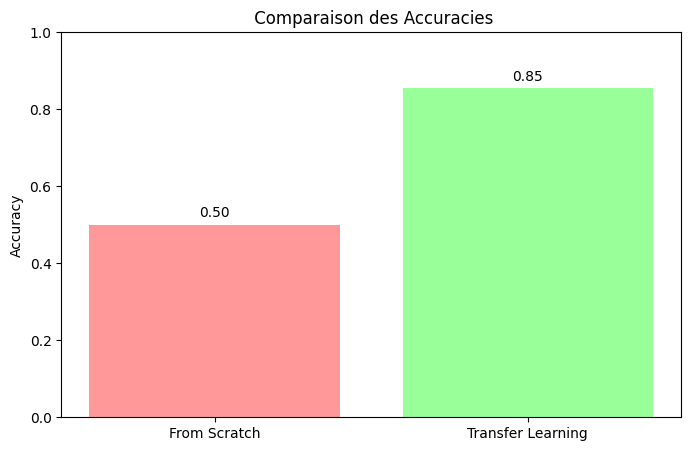

Visualisation terminée !


In [39]:
import matplotlib.pyplot as plt

# Données pour le graphique
models = ['From Scratch', 'Transfer Learning']
accuracies = [test_acc, test_acc_tl]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['#FF9999', '#99FF99'])
plt.title(' Comparaison des Accuracies')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center')
plt.show()
print("Visualisation terminée !")

### Organisation et soumission
Cette étape organise le projet pour GitHub et donne les instructions pour soumettre. Le notebook, requirements.txt, et README.md sont préparés. Soumets avant 18:00 GMT

cnn-catsdogs-Mamadou Sadialiou Diallo

├─ Projet_DL_MSD.ipynb

├─ .gitignore

├─ requirements.txt

├─ README.md

In [12]:
!apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.15).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [30]:
!rm -rf cnn-catsdogs-<momosadialiou221>
!mkdir cnn-catsdogs-<momosadialiou221>
%cd cnn-catsdogs-<momosadialiou221>

!git init
print(" Dépôt Git initialisé !")

/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `rm -rf cnn-catsdogs-<momosadialiou221>'
/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `mkdir cnn-catsdogs-<momosadialiou221>'
[Errno 2] No such file or directory: 'cnn-catsdogs-<momosadialiou221>'
/content
Reinitialized existing Git repository in /content/.git/
 Dépôt Git initialisé !


In [36]:
# Créer les fichiers nécessaires
%%writefile .gitignore
*.pth           # Ignorer les fichiers de modèle
__pycache__/    # Ignorer les dossiers de cache
*.ipynb_checkpoints/  # Ignorer les sauvegardes Colab
*.log           # Ignorer les logs


Overwriting .gitignore


In [37]:
%%writefile requirements.txt
torch
torchvision
matplotlib
tqdm

Overwriting requirements.txt


In [38]:
%%writefile README.md
# TP CNN Cats vs Dogs - <momohsadialiou221>

# Objectif
Classer des images de chats et chiens avec un CNN entraîné from scratch et une approche de Transfer Learning.

##  Environnement
Pour exécuter ce projet, installe les dépendances :
```bash
pip install -r requirements.txt

Overwriting README.md


In [39]:
!apt-get install git
!git config --global user.name "Momosadialiou221"
!git config --global user.email "momohsadialiou99@gmail.com"
print("✅ Git configuré !")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.15).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
✅ Git configuré !
